#### Survey Questionnaire

1. What is your age?

2. How many years have you been our customer?

3. Which channel do you use most often? (branch, mobile app, website, call center, ATM)

4. Rate your overall service (1 = very poor ... 5 = excellent)

5. How likely are you to recommend us? (0–10 scale)

6. What is your average monthly account balance (optional)

7. How many products do you use with us? (accounts/loans/cards/etc.) (optional)

8. How many branch visits did you make last month? (optional)

9. How many mobile-app logins did you make last month? (optional)

10. How many complaints/support tickets did you raise in the last year? (optional)

11. Which region do you belong to? (north/south/east/west/central) (optional)

12. Do you have our credit card? (yes/no) (optional)

13. What was your total commercial transaction amount last month (if any)? (optional)

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_classif

In [106]:
df = pd.read_csv("task4.csv")
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (100, 13)


,age,tenure_years,primary_channel,service_rating,nps,monthly_balance,num_products,branch_visits_last_month,app_logins_last_month,complaints_last_year,region,has_credit_card,commercial_ops_amount_last_month
0,56,12,website,1,2,21358,5,1,33,3,central,yes,4100.0
1,69,0,branch,5,6,4267,1,0,5,0,east,yes,0.0
2,46,24,call center,4,7,18209,4,2,1,3,west,yes,0.0
3,32,6,branch,3,3,25052,1,4,12,1,central,yes,4100.0
4,60,8,branch,1,1,39513,1,1,42,2,east,NaN,0.0


               age  tenure_years primary_channel  service_rating         nps  \
count   100.000000    100.000000             100       100.00000  100.000000   
unique         NaN           NaN               5             NaN         NaN   
top            NaN           NaN          branch             NaN         NaN   
freq           NaN           NaN              28             NaN         NaN   
mean     43.350000     10.390000             NaN         3.01000    4.680000   
std      14.904663      7.454773             NaN         1.43896    3.253219   
min      19.000000      0.000000             NaN         1.00000    0.000000   
25%      31.750000      4.000000             NaN         2.00000    2.000000   
50%      42.000000      9.000000             NaN         3.00000    4.000000   
75%      57.000000     16.000000             NaN         4.00000    8.000000   
max      69.000000     24.000000             NaN         5.00000   10.000000   

        monthly_balance  num_products  

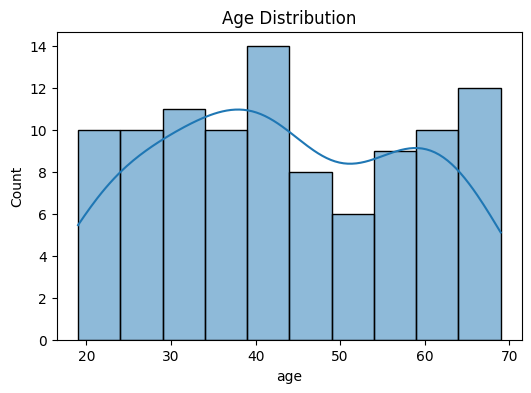

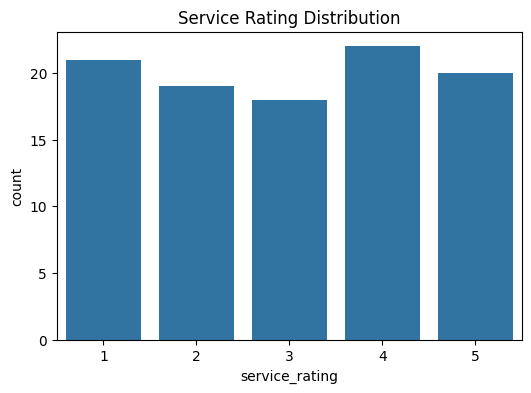

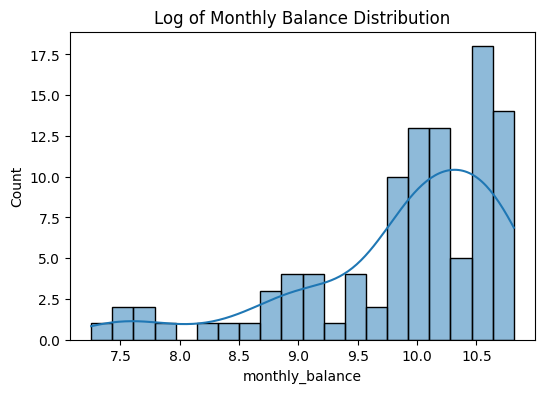

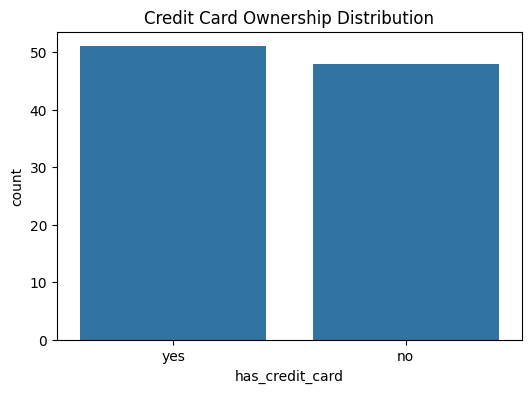

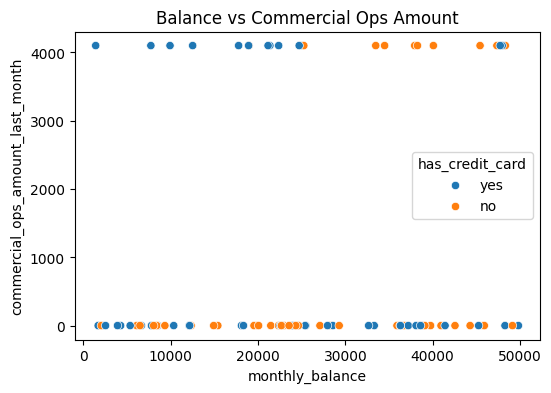

has_credit_card
yes    51.515152
no     48.484848
Name: proportion, dtype: float64

 primary_channel
branch         28.0
call center    24.0
website        23.0
mobile app     16.0
ATM             9.0
Name: proportion, dtype: float64

 region
central    26.262626
east       20.202020
north      20.202020
west       17.171717
south      16.161616
Name: proportion, dtype: float64


In [107]:
# C.
print(df.describe(include="all"))

# Histogram: Age
plt.figure(figsize=(6,4))
sns.histplot(df["age"], bins=10, kde=True)
plt.title("Age Distribution")
plt.savefig("age_hist.png")
plt.show()


# Service Rating bar
plt.figure(figsize=(6,4))
sns.countplot(x="service_rating", data=df)
plt.title("Service Rating Distribution")
plt.savefig("service_rating_bar.png")
plt.show()


# Monthly balance log-hist
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df["monthly_balance"]), bins=20, kde=True)
plt.title("Log of Monthly Balance Distribution")
plt.savefig("monthly_balance_loghist.png")
plt.show()

# Has credit card counts
plt.figure(figsize=(6,4))
sns.countplot(x="has_credit_card", data=df)
plt.title("Credit Card Ownership Distribution")
plt.savefig("has_credit_card_counts.png")
plt.show()

# Scatter: Balance vs Commercial Ops
plt.figure(figsize=(6,4))
sns.scatterplot(x="monthly_balance", y="commercial_ops_amount_last_month", hue="has_credit_card", data=df)
plt.title("Balance vs Commercial Ops Amount")
plt.savefig("balance_vs_commercial.png")
plt.show()

# Balance check across key categorical features
""" If one class has ~50% and the other ~50% → dataset is balanced.
    If one class dominates (like 80–90% vs 10–20%) → dataset is imbalanced."""

print(df["has_credit_card"].value_counts(normalize=True) * 100)

print("\n",df["primary_channel"].value_counts(normalize=True) * 100)

print("\n",df["region"].value_counts(normalize=True) * 100)


has_credit_card: Balanced (yes = 51%, no = 49%).

primary_channel: Moderately imbalanced (branch = 28% vs ATM = 9%).

region: Fairly balanced (16–26% across categories).

Overall: The dataset is mostly balanced, with only mild imbalance in primary_channel.

In [108]:
# D.
print("Before handling:",df.isnull().sum().sum())

# handle missing values
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("After handling:", df.isnull().sum().sum())


Before handling: 3
After handling: 0


Before oversampling:
primary_channel
branch         28
call center    24
website        23
mobile app     16
ATM             9
Name: count, dtype: int64

After oversampling:
primary_channel
ATM            91
branch         28
call center    24
website        23
mobile app     16
Name: count, dtype: int64


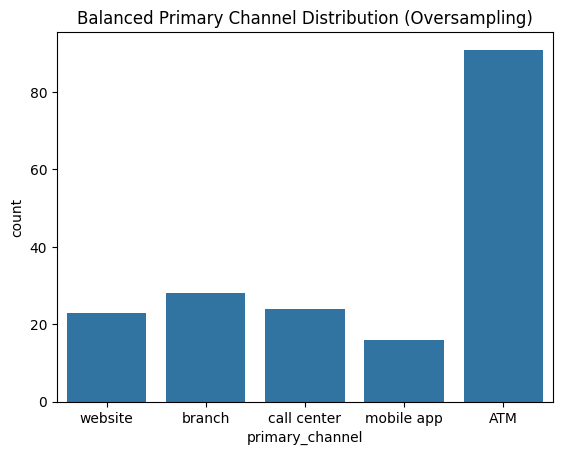

In [109]:
df_majority = df[df.primary_channel != "ATM"]
df_minority = df[df.primary_channel == "ATM"]

print("Before oversampling:")
print(df["primary_channel"].value_counts())

# Oversample minority (ATM) to match majority size
df_minority_upsampled = resample(
    df_minority,
    replace=True,                   
    n_samples=len(df_majority), 
    random_state=42
)

df_balanced_channel = pd.concat([df_majority, df_minority_upsampled])

print("\nAfter oversampling:")
print(df_balanced_channel["primary_channel"].value_counts())

sns.countplot(x="primary_channel", data=df_balanced_channel)
plt.title("Balanced Primary Channel Distribution (Oversampling)")
plt.show()


In [110]:
# F.
df_copy = df.copy()

X = df_copy.drop("has_credit_card", axis=1)
y = df_copy["has_credit_card"].map({"yes":1, "no":0})  # binary target

# Encode categorical features temporarily
X_enc = X.copy()
for col in X_enc.select_dtypes(include=["object"]).columns:
    X_enc[col] = X_enc[col].astype("category").cat.codes

mi = mutual_info_classif(X_enc, y, discrete_features="auto")
mi_scores = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)
print("\n--- Mutual Information Scores ---")
print(mi_scores)

selected_features = mi_scores.head(8).index.tolist()
print("\nSelected Features:", selected_features)


--- Mutual Information Scores ---
nps                                 0.052690
complaints_last_year                0.045542
commercial_ops_amount_last_month    0.043081
app_logins_last_month               0.022352
service_rating                      0.000000
primary_channel                     0.000000
tenure_years                        0.000000
age                                 0.000000
branch_visits_last_month            0.000000
num_products                        0.000000
monthly_balance                     0.000000
region                              0.000000
dtype: float64

Selected Features: ['nps', 'complaints_last_year', 'commercial_ops_amount_last_month', 'app_logins_last_month', 'service_rating', 'primary_channel', 'tenure_years', 'age']


In [111]:
# G.
df_dummy = pd.get_dummies(df, drop_first=True)
print("\nShape after Dummy Encoding:", df_dummy.shape)
df_dummy.to_csv("task4_dummy_encoded.csv", index=False)


Shape after Dummy Encoding: (100, 19)


In [112]:
# H.
print("Total duplicates:", df.duplicated().sum())

# Technique 1: Drop duplicates
df_no_dupes = df.drop_duplicates()

# Technique 2: Aggregate duplicates (group by region and average)
df_grouped = df.groupby("region").mean(numeric_only=True).reset_index()

print("After drop_duplicates:", df_no_dupes.shape)
print("After groupby aggregation:", df_grouped.shape)

Total duplicates: 0
After drop_duplicates: (100, 13)
After groupby aggregation: (5, 11)
